In [1]:
# Importar librerías 
import DataFunctions
import ModelFunctions
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from valuation import Companies, Models
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import numpy as np
import pandas as pd
#from ydata_profiling import ProfileReport

In [2]:
# Cargar Datos
income_statement = DataFunctions.load_full_excel('Data/Income/Income_Statement.xlsx')
balance_statement = DataFunctions.load_full_excel('Data/Balance/Balance_Statement.xlsx')
sp500 = DataFunctions.assets(income_statement=income_statement)

# Si se desea cambiar de periodo de analisis cambiar la siguiente fecha:
prices = yf.download(tickers=sp500, start='2018-09-01', end='2023-09-23', progress=False)['Adj Close'] 

# Filtrado de fechas y correcciones temporales
prices_fiscal = DataFunctions.prices_date(balance_statement=balance_statement, prices=prices, sp500=sp500)

# DataFrame limpio con información consolidada de ambos estados financieros y precios
financial_info = DataFunctions.clean_df(balance_statement=balance_statement, 
                                    income_statement=income_statement, 
                                    sp500=sp500, 
                                    prices_fiscal=prices_fiscal)

# Datos en formato tabular
data_table = DataFunctions.tabular_df(financial_info=financial_info, sp500=sp500)

# Cálculo de ratios financieros 
stock = Companies(data_table)
stock.get_ratios()

# EDA con miras a limpieza de datos
DataFunctions.dqr(stock.ratios)

# Limpieza
stock.clean_ratios()
stock.clean


1 Failed download:
['ABC']: Exception('%ticker%: No data found, symbol may be delisted')


,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM,Return
0,A,2023-06-30,117.226398,3.280427,26.970165,0.156505,484.824339,0.027984,0.866805,0.178804,1.866805,1
1,A,2023-03-31,115.687540,3.729464,12.466387,0.159538,473.104821,0.032237,0.946693,0.202067,1.946693,1
2,A,2022-12-31,119.300066,4.168479,76.111111,0.174041,425.001250,0.034941,0.985297,0.200764,1.985297,1
3,A,2022-09-30,108.403263,3.401819,14.888889,0.163201,419.650125,0.031381,1.059320,0.192285,2.059320,0
4,A,2022-06-30,128.247944,3.361065,15.462857,0.151698,416.910303,0.026208,1.041195,0.172762,2.041195,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14,XRAY,2019-12-31,197.198259,1.773366,4.074675,0.101090,520.351878,0.008993,0.990733,0.088959,1.990733,1
15,XRAY,2019-09-30,434.443191,1.833476,26.970165,0.116104,445.294066,0.004220,0.816937,0.036349,1.816937,0
16,XRAY,2019-06-30,450.749762,1.958478,26.970165,0.104921,447.986379,0.004345,0.760390,0.041411,1.760390,1
17,XRAY,2019-03-31,8354.719810,1.679903,26.970165,0.118376,407.148055,0.000201,0.777601,0.001699,1.777601,0


In [3]:
import joblib
from locale import setlocale, LC_TIME

database = stock.clean.copy()
loaded_model = joblib.load(open('GBC_bagging_model.pkl', 'rb'))

setlocale(LC_TIME, 'en_US.UTF-8')

# Model
#database.to_csv('data.csv')
data = pd.read_csv('data.csv').drop('Unnamed: 0', axis=1)
data['fiscalDateEnding'] = pd.to_datetime(data['fiscalDateEnding'], format='%Y-%m-%d')
data['Yhat'] = loaded_model.predict(data.drop(['Stock', 'fiscalDateEnding', 'Return'], axis=1))
data = data.sort_values(by = 'fiscalDateEnding', ascending = True)

# Prices
prices = stock.df[['Stock','fiscalDateEnding','Adj Close']]
prices = prices.sort_values(by = 'fiscalDateEnding')

data = data.merge(prices, how = 'left', on = ['fiscalDateEnding','Stock'])
data.head()

,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM,Return,Yhat,Adj Close
0,GEN,2018-12-31,-397.673958,0.371745,26.970165,0.071512,906.206897,-0.000935,0.862399,-0.013072,1.86327,0,0,9.880099
1,DISH,2018-12-31,18.623365,0.939512,41.532332,0.396907,209.470823,0.050448,0.862399,0.127103,1.86327,0,0,24.969999
2,DLTR,2018-12-31,103.204542,3.398345,26.970165,0.647207,20.407688,0.032928,0.862399,0.050877,1.86327,0,0,90.320000
3,DOV,2018-12-31,134.515580,2.472537,26.970165,0.204184,95.486986,0.018381,0.862399,0.090022,1.86327,0,0,65.714195
4,DOW,2018-12-31,0.000000,0.000000,26.970165,1.740944,8.315140,0.156812,0.862399,0.090073,1.86327,0,0,0.000000


In [4]:
rf = pd.read_csv("^IRX.csv")
rf.Date = pd.to_datetime(rf['Date'], format='%m/%d/%y')

rf["rf"] = rf["Adj Close"]
rf.drop(["Adj Close"],axis=1 ,inplace=True)

rf["fiscalDateEnding"] = rf.Date
rf.drop(["Date"],axis=1 ,inplace=True)

rf.fillna(method='ffill', inplace=True)

data = data.merge(rf, on="fiscalDateEnding")

investment_rf = {0: 1, 
                 1: 0.8, 
                 2: 0.6, 
                 3: 0.4, 
                 4: 0.2, 
                 5: 0}

initial_capital = 1000000
comission = .00025

#date = '2018-12-31'
date = '2019-06-30'
trade_period = data[data['fiscalDateEnding'] == date]

In [5]:
import AssetAllocation as AA

In [6]:
# ASSET PICKER
def pick_assets(data: pd.DataFrame, current_open_positions: pd.DataFrame, fiscal_date: str):
    # Previous Stocks Evaluation
    previous_stocks = data[(data['fiscalDateEnding'] == fiscal_date) & (data['Yhat'] == 1)].merge(current_open_positions.copy(), left_on='Stock', right_on='Asset', how = 'inner')
    previous_stocks = previous_stocks['Stock'].values
    # Add Missing Stocks
    new_assets = 5 - len(previous_stocks)
    try:
        add_assets = data[(data['fiscalDateEnding'] == fiscal_date) & (data['Yhat'] == 1)].sample(n = new_assets)['Stock'].values
        assets_list = list(previous_stocks) + list(add_assets) 
    except:
        assets_list = []
    return assets_list



In [7]:
# OMEGA ASSET ALLOCATION
def omegaAA(data: pd.DataFrame, assets: pd.DataFrame, assets_lists: list, fiscal_date: str, mkt_idx: str = '^GSPC'):
    # Omega Optimization
    rf_rate = data.rf.values[0] / 100
    if len(assets_lists) > 0:
        tickers = assets_lists.copy()
        tickers.append(mkt_idx)
        end_date = pd.to_datetime(fiscal_date)
        start_date = end_date + timedelta(days = -365)
        try:
            omega_prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
        except:
            try:
                omega_prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
            except:
                try:
                    omega_prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
                except:
                    omega_prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
        omega = AA.asset_allocation(data_stocks=omega_prices[omega_prices.columns[:-1]], data_benchmark=omega_prices[omega_prices.columns[-1]].to_frame(), rf=rf_rate)
        omega_weights = omega.omega(n_port=1)
    else:
        omega_weights = []
    # RF
    rf_percentage = (5 - len(omega_weights)) * .2
    if rf_percentage > 0:
        assets_lists = assets_lists + ['Rf']
        omega_weights = np.array(omega_weights) * (1 - rf_percentage)
        omega_weights = np.concatenate((omega_weights, [rf_percentage]))
        omega_weights = list(omega_weights).copy()

    # Assets DF
    new_assets = pd.DataFrame([ pd.to_datetime([fiscal_date for i in range(len(omega_weights))]),
                             assets_lists, omega_weights],
                           index=['Date','Stock','W']).transpose()
    assets = pd.concat([assets, new_assets], axis = 0, ignore_index = True)

    # Omega Weights
    omega_weights = {asset:[weight] for asset,weight in zip(assets_lists,omega_weights)}
    omega_weights = pd.DataFrame.from_dict(omega_weights).T.reset_index().rename(columns = {'index':'Stock',0:'Weight'})

    return omega_weights, assets

In [8]:
## Sell RF
def open_positions(current_open_positions: pd.DataFrame, consult_asset: str):
    return consult_asset in  current_open_positions.Asset.values

def valuate_position(current_open_positions: pd.DataFrame, consult_asset: str):
    rf_open_position = current_open_positions[current_open_positions['Asset'] == consult_asset]['X'].values[0]  
    position_date = current_open_positions[current_open_positions['Asset'] == consult_asset]['Date'].values[0]
    return   rf_open_position, position_date

def close_position(current_open_positions: pd.DataFrame):
    current_open_positions = current_open_positions[current_open_positions['Asset'] != 'Rf']
    return current_open_positions

def report_sale(operations: pd.DataFrame, rf_open_position: float, position_date: str, fiscal_date: str):
    previous_rf = operations[(operations['Date'] == position_date) & (operations['Asset'] == 'Rf') & (operations['Type'] == 'Buy')]['Price'].values[0] / 100
    income_risk_free =  rf_open_position * ( 1 + previous_rf *  3/12)
    sell_operation = pd.DataFrame([fiscal_date,'Rf',-income_risk_free,previous_rf,-income_risk_free,'Sell'], index = ['Date','Asset','X','Price','Position','Type']).T
    operations = pd.concat([operations,sell_operation], axis = 0, ignore_index = True)
    return operations, income_risk_free

def update_funds(income_risk_free: float):
    cash = income_risk_free
    return cash
    
def sell_rf(current_open_positions: pd.DataFrame, operations: pd.DataFrame, fiscal_date: str):
    if open_positions(current_open_positions, 'Rf'):
        rf_open_position, position_date = valuate_position(current_open_positions, 'Rf')
        current_open_positions = close_position(current_open_positions)
        operations, income_risk_free = report_sale(operations, rf_open_position, position_date, fiscal_date)
        cash = update_funds(income_risk_free)
    else:
        income_risk_free = 0
        cash = update_funds(income_risk_free)
    return current_open_positions, operations, cash

In [9]:
## Current Port Value
def previous_capitals_open(current_open_positions: pd.DataFrame):
    return len(current_open_positions[current_open_positions['Asset'] != 'Rf']['Asset'].values) > 0

def get_market_prices(tickers, start_date: str, end_date: str):
    # Error Handling with API Connection
    try:
        prices_new = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
    except:
        try:
            prices_new = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
        except:
            try:
                prices_new = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
            except:
                prices_new = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
    prices_new = prices_new.iloc[0]
    prices_new = prices_new.to_frame()
    prices_new.columns = ['Price']
    #prices_new = prices_new.reset_index()
    #prices_new = prices_new.rename(columns = {'Stock':'Asset'})
    #prices_new = prices_new.set_index('Stock')
    return prices_new

def current_position_value(current_open_positions: pd.DataFrame, fiscal_date: str):
    tickers_previous = list(current_open_positions[current_open_positions['Asset'] != 'Rf']['Asset'].values)

    end_date = pd.to_datetime(fiscal_date) + timedelta(days=7)
    end_date = end_date.strftime('%Y-%m-%d')

    previous_portfolio = current_open_positions[['Asset','X','Price']].set_index('Asset')
    prices_new = get_market_prices(tickers_previous, start_date=fiscal_date, end_date= end_date).iloc[0]
    
    previous_portfolio = previous_portfolio.merge(prices_new, left_index = True, right_index = True, how = 'left')
    previous_portfolio['Pos'] = previous_portfolio['X'] * previous_portfolio['Price']
    previous_portfolio = previous_portfolio.rename(columns = {'X':'X_1'})
    
    capitals_value = previous_portfolio['Pos'].sum()
    return previous_portfolio, capitals_value

def overall_portfolio_value(capitals_value: float, cash: float):
    return capitals_value + cash

def no_previous_capital_open():
    return pd.DataFrame(columns = ['Stock','X_1']).set_index('Stock')

def current_portfolio_value(current_open_positions: pd.DataFrame, cash: float, fiscal_date: str):
    if previous_capitals_open(current_open_positions):
        previous_portfolio, capitals_value = current_position_value(current_open_positions, fiscal_date)
        cash = overall_portfolio_value(capitals_value, cash)
    else:
        previous_portfolio = no_previous_capital_open()
        cash = cash # No aditional cash from capitals

    return previous_portfolio, cash

In [10]:
## Trade Capitals
def adjustments_to_portofolio(omega_weights: pd.DataFrame, previous_portfolio: pd.DataFrame, cash: float, fiscal_date: str, comission: float = .00025):
    Xt = omega_weights[omega_weights['Stock'] != 'Rf'].copy()
    end_date = pd.to_datetime(fiscal_date) + timedelta(days=7)
    end_date = end_date.strftime('%Y-%m-%d')
    tickers = list(Xt['Stock'].values) + list(previous_portfolio.index.values)

    if len(tickers) > 0:
        try:
            prices_new = get_market_prices(tickers=tickers, start_date=fiscal_date, end_date= end_date)
        except:
            prices_new = pd.DataFrame(columns = ['Price'])
    else:
        prices_new = pd.DataFrame(columns = ['Price'])

    Xt = Xt.rename(columns={'Stock':'Asset'})
    Xt = Xt.set_index('Asset')
    X = Xt.join(previous_portfolio['X_1'], how='outer').fillna(0.0)
    X = X.merge(prices_new, left_index = True, right_index = True, how = 'left') 
    X["X"] = (X['Weight'] * cash / X['Price']).apply(lambda x: np.floor(x))
    X['Trade'] = X['X'] - X['X_1']

    # Only capitals
    X = X.reset_index().rename(columns = {'Stock':'Asset','index':'Asset'})
    
    # Cash withdrawl
    stocks_cash = cash
    cash = cash * ( 1 - X['Weight'].sum() )

    if (X['Weight'] * stocks_cash).sum() > (X['X'] * X['Price']).sum():
        remaining = (X['Weight'] * stocks_cash).sum() - (X['X'] * X['Price']).sum()
        cash =+ remaining
    # Sell 
    to_sell = X['Trade']<0
    if len(X[to_sell]) > 0:
        assets_to_sell =np.floor((X[to_sell].Trade)) / (1 + comission)
        cash_gain_per_asset = assets_to_sell * X[to_sell]['Price'] 
        operations_sell = assets_to_sell.to_frame().rename(columns = {'Trade':'X'})
        operations_sell['Price'] = X[to_sell]['Price'].values
        operations_sell['Asset'] = X[to_sell]['Asset'].values
        operations_sell['Position'] = cash_gain_per_asset.T.values
        operations_sell['Type'] = 'Sell'
        operations_sell['Date'] = fiscal_date
    else:
        #net_cash_gain = 0
        operations_sell = pd.DataFrame(columns=['Date','Asset','X','Price','Position','Type'])
    
    # Buy
    to_buy = X['Trade']>0
    if len(X[to_buy]) > 0:
        assets_to_buy = np.floor((X[to_buy].Trade) / (1 + comission))
        cash_invest_per_asset = assets_to_buy * X[to_buy]['Price']
        #net_cash_invest = cash_invest_per_asset.sum(axis=1)
        operations_buy = assets_to_buy.to_frame().rename(columns = {'Trade':'X'})
        operations_buy['Price'] = X[to_buy]['Price'].values
        operations_buy['Asset'] = X[to_buy]['Asset'].values
        operations_buy['Position'] = cash_invest_per_asset.T.values
        operations_buy['Type'] = 'Buy'
        operations_buy['Date'] = fiscal_date
    else:
        operations_buy = pd.DataFrame(columns=['Date','Asset','X','Price','Position','Type'])

    new_operations = pd.concat([operations_sell,operations_buy], axis = 0, ignore_index = True)
    return new_operations, cash

def close_capitals_position(current_open_positions: pd.DataFrame, new_operations: pd.DataFrame):
    sell_operations = new_operations[new_operations['Type'] == 'Sell']
    amount_open = current_open_positions[['Asset','X','Price']]
    amount_to_close = sell_operations[['Date','Asset','X','Price']]
    for stock in amount_to_close.Asset.values:
        if stock in amount_open.Asset.values:
            asset_open = amount_open[amount_open.Asset == stock]
            asset_to_close = amount_to_close[amount_to_close.Asset == stock]
            remaining_open = asset_open.X.iloc[0] + asset_to_close.X.iloc[0]
            if remaining_open > 0:
                price = asset_open.Price.iloc[0]
                new_open_date = asset_to_close.Date.iloc[0]
                current_open_positions = current_open_positions[current_open_positions['Asset'] != stock]
                new_entry = pd.DataFrame([new_open_date, stock, remaining_open, price], index=['Date','Asset','X','Price']).T
                current_open_positions = pd.concat([current_open_positions, new_entry], axis=0, ignore_index=True)
            else:
                current_open_positions = current_open_positions[current_open_positions['Asset'] != stock]
        else:
            pass
    return current_open_positions

def open_capitals_position(current_open_positions: pd.DataFrame, new_operations: pd.DataFrame): 
    buy_operations = new_operations[new_operations['Type'] == 'Buy']
    amount_open = current_open_positions[['Asset', 'X', 'Price']]
    amount_to_open = buy_operations[['Date', 'Asset', 'X', 'Price']]
    for stock in amount_to_open['Asset'].values:
        if stock in amount_open['Asset'].values:
            asset_open = amount_open[amount_open['Asset'] == stock]
            asset_to_open = amount_to_open[amount_to_open['Asset'] == stock]
            remaining_open = asset_open['X'].iloc[0] + asset_to_open['X'].iloc[0]
            price = (asset_open['Price'].iloc[0] * asset_open['X'].iloc[0] + asset_to_open['Price'].iloc[0] * asset_to_open['X'].iloc[0]) / remaining_open 
            current_open_positions = current_open_positions[current_open_positions['Asset'] != stock]
            new_open_date = asset_to_open['Date'].iloc[0]
            new_entry = pd.DataFrame([[new_open_date, stock, remaining_open, price]], columns=['Date', 'Asset', 'X', 'Price'])
            current_open_positions = pd.concat([current_open_positions, new_entry], ignore_index=True)
        else:
            asset_to_open = amount_to_open[amount_to_open['Asset'] == stock]
            remaining_open = asset_to_open['X'].iloc[0]
            price = asset_to_open['Price'].iloc[0]
            new_open_date = asset_to_open['Date'].iloc[0]
            new_entry = pd.DataFrame([[new_open_date, stock, remaining_open, price]], columns=['Date', 'Asset', 'X', 'Price'])
            current_open_positions = pd.concat([current_open_positions, new_entry], ignore_index=True)
    return current_open_positions

def report_operations(operations: pd.DataFrame, new_operations: pd.DataFrame):
    return pd.concat([operations, new_operations], axis=0, ignore_index=True)

def trade_capitals(current_open_positions: pd.DataFrame, operations: pd.DataFrame, omega_weights:pd.DataFrame, 
                   previous_portfolio: pd.DataFrame, cash: float, fiscal_date: pd.DataFrame, comission: float = .00025):
    
    new_operations, cash = adjustments_to_portofolio(omega_weights, previous_portfolio, cash, fiscal_date, comission)
    current_open_positions = close_capitals_position(current_open_positions, new_operations)
    current_open_positions = open_capitals_position(current_open_positions, new_operations)
    operations = report_operations(operations, new_operations)
    return current_open_positions, operations, cash
        


In [11]:
## Buy RF
def invest_in_rf(cash: float):
    print('CASH: ',cash)
    return cash > 0

def open_rf_position(data: pd.DataFrame, current_open_positions: pd.DataFrame, cash: float, fiscal_date: str):
    rf = data[data['fiscalDateEnding'] == fiscal_date]['rf'].iloc[0] / 100
    buy_risk_free = cash
    open_pos = pd.DataFrame([fiscal_date,'Rf',buy_risk_free,rf], index = ['Date','Asset','X','Price']).T
    current_open_positions = pd.concat([current_open_positions,open_pos], axis = 0, ignore_index=True)
    return current_open_positions

def report_operation_rf(data: pd.DataFrame, operations: pd.DataFrame, cash: float, fiscal_date: pd.DataFrame):
    rf = data[data['fiscalDateEnding'] == fiscal_date]['rf'].iloc[0] / 100
    buy_risk_free = cash
    new_op = pd.DataFrame([fiscal_date,'Rf',buy_risk_free,rf,buy_risk_free,'Buy'], index = ['Date','Asset','X','Price','Position','Type']).T
    operations = pd.concat([operations,new_op], axis = 0, ignore_index=True)
    return operations

def buy_rf(data: pd.DataFrame, current_open_positions: pd.DataFrame, operations: pd.DataFrame, cash:float, fiscal_date: str):
    if invest_in_rf:
        current_open_positions = open_rf_position(data, current_open_positions, cash, fiscal_date)
        operations = report_operation_rf(data, operations, cash, fiscal_date)
    else:
        pass
    return current_open_positions, operations

In [12]:
## Reporting
def exercise_report(operations: pd.DataFrame):
    value_in_time = operations[operations['Type'] == 'Buy'].groupby('Date')['Position'].sum().to_frame()
    return value_in_time

In [13]:
## Trade Function
def TradeCapitals(current_open_positions: pd.DataFrame, operations: pd.DataFrame, omega_weights: pd.DataFrame, fiscal_date: str,initial_cycle: bool = False ,initial_capital: int = 1000000, comission: float = .00025):
    current_open_positions, operations, cash = sell_rf(current_open_positions, operations, fiscal_date)
    if initial_cycle:
        cash = initial_capital
    previous_portfolio, cash = current_portfolio_value(current_open_positions, cash, fiscal_date)
    current_open_positions, operations, cash = trade_capitals(current_open_positions, operations, omega_weights, previous_portfolio, cash, fiscal_date, comission)
    current_open_positions, operations = buy_rf(data, current_open_positions, operations, cash, fiscal_date)
    return current_open_positions, operations

In [47]:
## Backtesting Function
def BackTesting(data: pd.DataFrame):
    assets = pd.DataFrame(columns=['Date','Stock','W'])
    current_open_positions = pd.DataFrame(columns=['Date','Asset','X','Price'])
    operations = pd.DataFrame(columns=['Date','Asset','X','Price','Position','Type'])
    first_date = data['fiscalDateEnding'].unique()[0].strftime('%Y-%m-%d')
    wo_abc = data[data['Stock'] != 'ABC']

    for fiscal_date in data['fiscalDateEnding'].unique():
        fiscal_date = fiscal_date.strftime('%Y-%m-%d')
        assets_list = pick_assets(data=wo_abc, current_open_positions=current_open_positions, fiscal_date=fiscal_date)
        omega_weights, assets = omegaAA(data=wo_abc, assets=assets, assets_lists=assets_list, fiscal_date=fiscal_date)
        if fiscal_date == first_date:
            current_open_positions, operations = TradeCapitals(current_open_positions, operations, omega_weights,
                                                                        fiscal_date, True)
        else:
            current_open_positions, operations = TradeCapitals(current_open_positions, operations, omega_weights, fiscal_date)
    value_in_time = exercise_report(operations)
    return value_in_time, operations

In [52]:
import warnings
warnings.filterwarnings("ignore")

value_in_time, operations = BackTesting(data)

<Axes: xlabel='Date'>

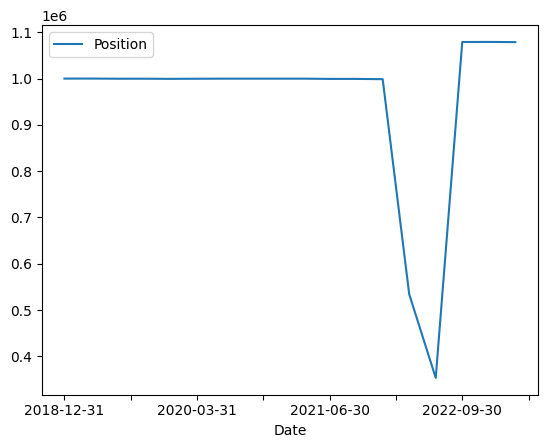

In [53]:
value_in_time.plot()

In [51]:
n = 5
tests = [BackTesting(data) for i in range(n)]
timelines = [tests[i][0] for i in range(n)]

AttributeError: 'numpy.float64' object has no attribute 'to_frame'

In [ ]:
[timelines[i].iloc[-1].values[0] for i in range(n)]

[-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0]